# Correlated features + practical procedure

Assumption $2.4$ (Correlated features). $\Sigma$ is a deterministic positive definite matrix, and there exists constants $C_0, C_1$ satisfying $0<C_0 \leq \lambda_{\min }(\Sigma) \leq \lambda_{\min }(\Sigma) \leq C_1$ for all $n, p$. Define the empirical spectral distribution (ESD) of $\Sigma$ as $F^{\Sigma}(x)=\frac{1}{p} \sum_{i=1}^p \mathbb{1}\left\{\lambda_i(\Sigma) \leq x\right\}$. Assume that as $p \rightarrow \infty$, the ESD $F^{\Sigma}$ converges weakly to a probability measure $H$.

In [3]:
from sklearn.base import RegressorMixin
from scipy.stats import ortho_group # orthogonal matrix
from scipy.optimize import fsolve   # solve function

import numpy as np
import math

import os 
import json
import codecs

from joblib import Parallel, delayed

import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt 

$\Sigma=\sum_{i=1}^p \lambda_i v_i v_i^T$, we consider eigenvalues $\lambda$
- half of the $\lambda_i = 1$, and half of the $\lambda_i = 2$

In [4]:
lambda1 = list(np.ones(12) * 2) + list(np.ones(12) * 1)

In [5]:
def fn(c, x, phi, psi):
    sum_ = [i/(-c + i * psi / phi) for i in x]
    return np.mean(sum_) - 1

def unique_c0_op(lambda1, phi, psi, init=-4):
    c0 = fsolve(fn, args=(lambda1, phi, psi), x0=init)
    if fn(c0, lambda1, phi, psi) < 1e-7:
        return c0
    else:
        print("Specify another starting point for the optimization method")

In [6]:
def gn(c, x, phi, psi):
    sum_ = [i/(-c + i * phi) for i in x]
    return np.mean(sum_) - 1/psi

def unique_c0_up(lambda1, phi, psi, init=4):
    c0 = fsolve(gn, args=(lambda1, phi, psi), x0=init)
    if gn(c0, lambda1, phi, psi) < 1e-7:
        return c0
    else:
        print("Specify another starting point for the optimization method")

## Sketched estimator

In [7]:
class SketchedRidgelessRegressor(RegressorMixin):
    """Sketched Ridgeless regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y, m, is_orthogonal=True):
        n = x.shape[0]
        p = x.shape[1]
        
        # Fixed S
        np.random.seed(1234)

        if is_orthogonal:
            S = ortho_group.rvs(dim=n)[0:m, :]  # orthogonal schetching matrix
        else:
            S = np.random.normal(size=(m, n), scale=1/np.sqrt(n))    # iid schetching matrix

        sx = np.matmul(S, x)
        sy = np.matmul(S, y)

        # xxinv = np.linalg.pinv(np.matmul(sx.T, sx))
        # xy = np.matmul(sx.T, sy)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(sx.T, sx)/n + 1e-6 * Ip)
        xy = np.matmul(sx.T, sy)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

In [8]:
class RidgelessLinearRegressor(RegressorMixin):
    """Ridgeless linear regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y):
        n = x.shape[0]
        p = x.shape[1]
        
        #xxinv = np.linalg.pinv(np.matmul(x.T, x))
        #xy = np.matmul(x.T, y)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(x.T, x)/n + 1e-6 * Ip)
        xy = np.matmul(x.T, y)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

In [9]:
def asy_risk_no_sketching(n, p, alpha, lambda_op, sigma):
    
    phi = p / n
    
    psi = 1
    
    condition = phi / psi
    condition_inv = psi / phi

    # gamma < 1
    if phi < 1:
        return sigma**2 * phi / (1 - phi)
    
    c0_op = unique_c0_op(lambda_op, phi, psi, init=-1)[0]

    # gamma > 1
    if phi > 1:
        b_op = -alpha**2 * c0_op
        numerator_ = np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        denominator_ = 1 - np.mean([i**2 * condition_inv / (c0_op - i * condition_inv)**2 for i in lambda_op])
        v_op = sigma**2 * numerator_ / denominator_
        return b_op + v_op

## Case 1: Orothogonal matrix

In [10]:
def gen_correlated_train_dat(n_train, n_features, alpha, x_sigma, sigma, seed):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    #bet = norm / np.sqrt(p) * np.ones(p) 
    
    # seed for X 
    np.random.seed(1234)
    
    # Assumption 2.4 (correlated features)
    x = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_train))
    
    # seed for eps
    np.random.seed(seed+3524)
    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features)  #from guassian prior
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet) + eps

    return x, y, bet

def gen_correlated_val_dat(n_val, n_features, beta, x_sigma, sigma, seed):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """
    
    # seed for X 
    np.random.seed(3213)
    # Assumption 2.4 (correlated features)
    x = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_val))
    
    # seed for eps
    np.random.seed(seed+1244)
    eps = np.random.normal(size=n_val, scale=sigma)
    y = np.matmul(x, beta) + eps

    return x, y

def gen_correlated_test_dat(n_test, n_features, beta, x_sigma, sigma, seed):
    
    # seed for x0 and eps
    np.random.seed(seed+1234)
    
    x0 = np.random.multivariate_normal(mean=np.zeros(n_features), cov=x_sigma, size=(n_test))
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x0, beta) + eps

    return x0, y

def optimal_m_empirical(x, y, m, is_orthogonal, x_val, beta):
    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    val_mse = np.mean((np.matmul(x_val, ridgeless.beta) - np.matmul(x_val, beta))**2)
    
    return val_mse


def simulate_sketching(n_train, n_features, alpha, sigma, x_sigma, seed, is_orthogonal=True, n_val=100, n_test=400, n_psi=40):
    
    # train
    x, y, beta = gen_correlated_train_dat(n_train, n_features, alpha, x_sigma, sigma, seed)  
    
    # val 
    x_val, y_val = gen_correlated_val_dat(n_val, n_features, beta, x_sigma, sigma, seed)
    
    # select optimal m
    mse_optimal_m = []
    psi = list(np.linspace(0.1, 0.49, int(n_psi/2))) + list(np.linspace(0.51, 0.99, int(n_psi/2)))
    mm = [int(ppsi * n_train) for ppsi in psi]
    mse_optimal_m = Parallel(n_jobs=-1)(delayed(optimal_m_empirical)(x, y, mm[j], is_orthogonal, x_val, beta) for j in range(n_psi))
    
    # If decreasing in the tail but min not attain at the end (due to numerical instability), then get m = n
    if n_train - mm[np.nanargmin(mse_optimal_m)] < 50:
        opt_m = n_train
    else:
        opt_m = mm[np.nanargmin(mse_optimal_m)]
    
    # plot empirical risk when selecting optimal m
    
    # if seed == 12341: 
    #     plt.clf()        
    #     ax = sns.lineplot(x=psi, y=mse_optimal_m)
    #     ax.set_ylim(-2, 60)
    #     ax.set_title("n features: " + str(n_features) + ", optimal m: " + str(opt_m) + ", phi :" + str(n_features/n_train) + ", " + str(mse_optimal_m[-1] - mse_optimal_m[0]))
    #     ax.set_ylabel("Out-of-sample Risk")
    #     ax.set_xlabel(r"$\psi$ = m/n")
    #     plt.show()
    
    # test
    x_oos, y_oos = gen_correlated_test_dat(n_test, n_features, beta, x_sigma, sigma, seed)

    # fit ridgeless least square using sketching matrix
    
    if opt_m == n_train:
        ridgeless = RidgelessLinearRegressor()
        ridgeless = ridgeless.fit(x, y)
    else:   
        ridgeless = SketchedRidgelessRegressor()
        ridgeless = ridgeless.fit(x, y, opt_m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

In [11]:
n_train = 400
n_test = 100
n_val = 200

alpha = 6
sigma = 3.0
seed = 12341
n_sim = 500

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80           # number of points in the graph for visualizing theorem 3.2 (line)

#### Numerical simulations

In [ ]:
%%time
pp = np.zeros(n_pts, dtype=int)
mse_sketch = np.zeros(n_pts)

phi_range = list(np.logspace(-1, 1, n_pts))


for i in len(phi_range):
    pphi = phi_range[i]
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 
    sigma_x = np.diag(lambda_op)
   
    # Sketching
    mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, pp[i], alpha, sigma, sigma_x, seed+j, is_orthogonal=True, n_val=n_val, n_test=n_test, n_psi=20) for j in range(n_sim)) 
    mse_sketch[i] = np.mean(mse_oos_sketch)
    
    print(pphi, mse_sketch[i])

In [15]:
alpha, sigma, emp_phi, emp_sketch_risk1, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_200.json')

In [18]:
data = {
    "s_orthogonal": 1,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": emp_phi,
    "emp_sketch_risk": emp_sketch_risk1,
    "phi": phi_asy,
    "ridgeless_risk": ridgeless_risk
}

save_path = "../result/practical_procedure/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'snr' + str(alpha/sigma) + '_200.json', 'w') as file:
    json.dump(data, file,indent=4)

In [12]:
import pandas as pd

df = pd.DataFrame()
df['phi_range'] = phi_range
df['mse_sketch'] = mse_sketch

## Asymptotic 

In [13]:
pp = np.zeros(n_pts_asymp, dtype=int)
mse_original = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 
    mse_original[i] = asy_risk_no_sketching(n_train, pp[i], alpha, lambda_op, sigma) 

In [14]:
data = {
    "s_orthogonal": 1,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": phi_range,
    "emp_sketch_risk": df['mse_sketch'].to_list(),
    "phi": phi,
    "ridgeless_risk": mse_original.tolist()
}

save_path = "../result/practical_procedure/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'snr' + str(alpha/sigma) + '_200.json', 'w') as file:
    json.dump(data, file,indent=4)

In [12]:
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_phi = file["emp_phi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    
    phi = file["phi"]
    ridgeless_risk = file["ridgeless_risk"]

    return file["alpha"], file["sigma"], emp_phi, emp_sketch_risk, phi, ridgeless_risk

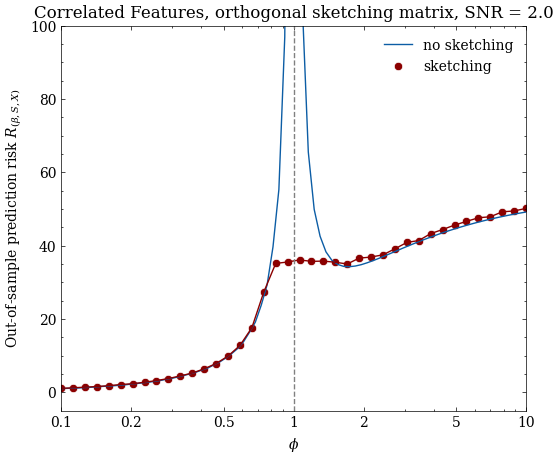

In [14]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    #ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk)
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_200.json')

    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', label="sketching")
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)

    ax.set_title("Correlated Features, orthogonal sketching matrix, SNR = 2.0")
    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, S, X)}$")
    ax.set_xlabel(r"$\phi$")

    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

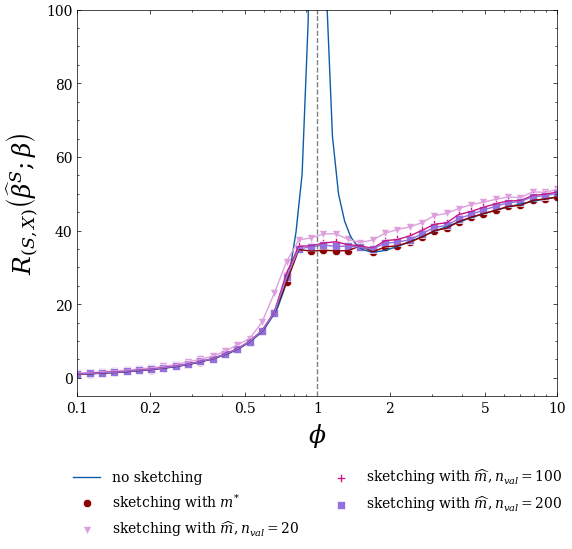

In [16]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json')
    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', label=r"sketching with ${m^{*}}$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_20.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='plum')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="v", color='plum', label=r"sketching with $\widehat{m}, n_{val}=20$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_100.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumvioletred')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="P", color='mediumvioletred', label=r"sketching with $\widehat{m}, n_{val}=100$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_200.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple', marker="s", label=r"sketching with $\widehat{m}, n_{val}=200$")
    
    
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    #ax.set_title("Correlated features, orthogonal sketching matrix, SNR = 2.0")
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)
    #ax.legend(loc='lower right', prop={'size':9})
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor =(0.5, -0.4), ncol = 2, prop={'size':10})
    
    ax.set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax.set_xlabel(r"$\phi$", fontsize=18)
    
    
    plt.tight_layout()

    

    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

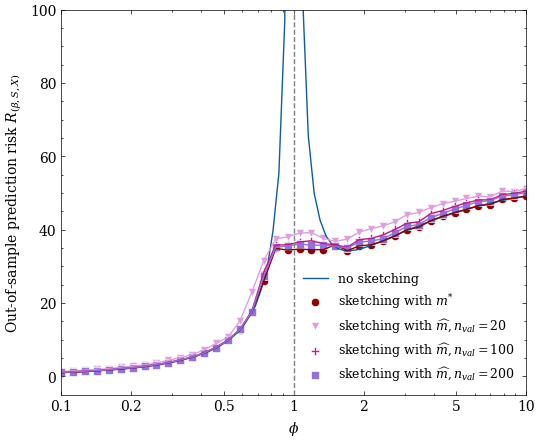

In [17]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json')
    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', label=r"sketching with ${m^{*}}$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_20.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='plum')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="v", color='plum', label=r"sketching with $\widehat{m}, n_{val}=20$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_100.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumvioletred')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="P", color='mediumvioletred', label=r"sketching with $\widehat{m}, n_{val}=100$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_200.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple', marker="s", label=r"sketching with $\widehat{m}, n_{val}=200$")
    
    
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    #ax.set_title("Correlated features, orthogonal sketching matrix, SNR = 2.0")
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)
    ax.legend(loc='lower right', prop={'size':9})
    
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels, loc='lower center', bbox_to_anchor =(0.5, -0.4), ncol = 2, prop={'size':10})
    
    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, S, X)}$")
    ax.set_xlabel(r"$\phi$")
    

    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

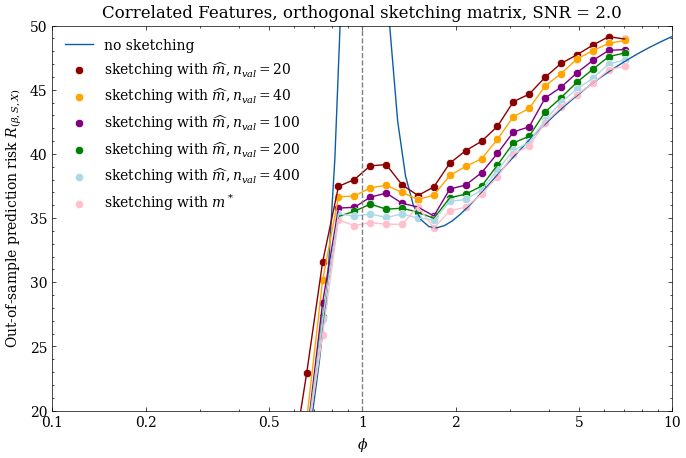

In [18]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    #ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk)
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_20.json')

    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    
    ax = sns.scatterplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='darkred', label=r"sketching with $\widehat{m}, n_{val}=20$")
    ax = sns.lineplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='darkred')
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_40.json') 
    ax = sns.scatterplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='orange', label=r"sketching with $\widehat{m}, n_{val}=40$")
    ax = sns.lineplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='orange')

    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_100.json') 
    ax = sns.scatterplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='purple', label=r"sketching with $\widehat{m}, n_{val}=100$")
    ax = sns.lineplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='purple')
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_200.json') 
    ax = sns.scatterplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='green', label=r"sketching with $\widehat{m}, n_{val}=200$")
    ax = sns.lineplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='green')
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_400.json') 
    ax = sns.scatterplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='lightblue', label=r"sketching with $\widehat{m}, n_{val}=400$")
    ax = sns.lineplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='lightblue')
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json') 
    ax = sns.scatterplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='pink', label=r"sketching with $m^*$")
    ax = sns.lineplot(x=emp_phi[:37], y=emp_sketch_risk[:37], color='pink')
      
    ax.set_ylim(20, 50)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)

    ax.set_title("Correlated Features, orthogonal sketching matrix, SNR = 2.0")
    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(\beta, S, X)}$")
    ax.set_xlabel(r"$\phi$")

    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()